# Deep Learning Tabular Data

In [1]:
%matplotlib inline
from utility_funcitons import *
from feature_selection import *
import pandas as pd 
import numpy as np


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_features, test_features, feature_names = featurize(train, test, 'tfidf_glove')

y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)

Starts with number....
Clickbait Phrases....
Clickbait re....
Num dots....
Text Features....
Punctuation....
Word ratios....
Sentiment Scores....
Readability Scores....



Glove.....



DONE!


In [5]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):/
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = 4, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)


def fit_n_times(model, x_train, y_train, x_test, y_test, n_iters = 10):
    metrics = np.zeros(5)
    for _ in range(n_iters):
        model.fit(x_train, y_train)
        y_test_prob = model.predict_proba(x_test)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, verbose = False, return_metrics = True)
    metrics /=10
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))



SyntaxError: invalid syntax (<ipython-input-5-b160a80dc31b>, line 12)

In [6]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 40

simple_nn = Sequential()
simple_nn.add(Dense(150, activation='relu', input_shape=(119,)))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid'))

simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('./saved_models', monitor = 'val_accuracy', verbose = 1, save_best_only=True)

history = simple_nn.fit(train_features.todense(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint],
                    validation_data=(test_features.todense(), y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 150)               18000     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 33,201
Trainable params: 33,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/8 [==>...........................] - 

Epoch 22/40
1/8 [==>...........................] - ETA: 0s - loss: 0.0525 - accuracy: 0.9766
Epoch 00022: val_accuracy did not improve from 0.98055
8/8 [==============================] - 0s 23ms/step - loss: 0.0501 - accuracy: 0.9810 - val_loss: 0.0591 - val_accuracy: 0.9791
Epoch 23/40
1/8 [==>...........................] - ETA: 0s - loss: 0.0361 - accuracy: 0.9844
Epoch 00023: val_accuracy did not improve from 0.98055
8/8 [==============================] - 0s 23ms/step - loss: 0.0527 - accuracy: 0.9800 - val_loss: 0.0578 - val_accuracy: 0.9790
Epoch 24/40
1/8 [==>...........................] - ETA: 0s - loss: 0.1000 - accuracy: 0.9609
Epoch 00024: val_accuracy improved from 0.98055 to 0.98105, saving model to ./saved_models
INFO:tensorflow:Assets written to: ./saved_models/assets
8/8 [==============================] - 1s 118ms/step - loss: 0.0445 - accuracy: 0.9870 - val_loss: 0.0524 - val_accuracy: 0.9811
Epoch 25/40
1/8 [==>...........................] - ETA: 0s - loss: 0.0791 - ac

In [7]:


from tensorflow.keras.models import load_model

simple_nn = load_model('./saved_models')

y_pred_prob = simple_nn.predict(test_features.todense())
print_model_metrics(y_test, y_pred_prob)

F1: 0.983 | Pr: 0.984 | Re: 0.982 | AUC: 0.998 | Accuracy: 0.983 



## Bagging

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

svm = SVC(C = 10, kernel = 'poly', degree = 2, probability = True, verbose = 0)

svm_bag = BaggingClassifier(svm, n_estimators = 200, max_features = 0.9, max_samples = 1.0, bootstrap_features = False, bootstrap = True, n_jobs = 1, verbose = 0)

svm_bag.fit(train_features, y_train)
y_test_prob = svm_bag.predict_proba(test_features)[:,1]
print_model_metrics(y_test, y_test_prob)

F1: 0.983 | Pr: 0.979 | Re: 0.987 | AUC: 0.998 | Accuracy: 0.983 



## Stacking Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log', alpha = 0.1, penalty = 'elasticnet')
svm = SVC(C = 10, kernel = 'poly', degree = 2, probability = True)
nb = MultinomialNB(alpha = 10000, class_prior = [0.5, 0.5])
knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', n_jobs = 2)
rf = RandomForestClassifier(n_estimators = 250, min_samples_split = 5, max_depth = 15,  n_jobs = -1)
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.3, max_depth = 1, n_jobs = -1)

model_dict = dict(zip(['LR', 'SVM', 'NB', 'KNN', 'XGB', 'RF'], [lr, svm, nb, knn, xgb, rf]))

for model_name, model in model_dict.items():
    print('Training {}'.format(model_name))
    if model_name == 'XGB':
        model.fit(train_features.todense(), y_train)
    else:
        model.fit(train_features, y_train)

model_weights = {   'LR' : 0.9,
                    'SVM' : 0.9,
                    'NB' : 0.8,
                    'KNN' : 0.75,
                    'RF' : 0.75,
                    'XGB' : 0.6,
                    'simple_nn' : 0.7
}

y_pred_prob = 0

for model_name, model in model_dict.items():
    if model_name == 'XGB':
        y_pred_prob += (model.predict_proba(test_features.todense())[:,1] * model_weights[model_name])
    else:
        y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob)

Training LR
Training SVM
Training NB
Training KNN
Training XGB
Training RF
F1: 0.985 | Pr: 0.980 | Re: 0.989 | AUC: 0.999 | Accuracy: 0.985 



In [10]:
def run_voting_clf(model_weights):
    y_pred_prob = 0

    for model_name, model in model_dict.items():
        if model_name == 'XGB':
            y_pred_prob += (model.predict_proba(test_features.todense())[:,1] * model_weights[model_name])
        else:   
            y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

    #y_pred_prob += (simple_nn.get_preds(ds_type = DatasetType.Valid)[0].numpy()[:,0] * model_weights['simple_nn'])
    y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
    y_pred_prob /= sum(model_weights.values())
    f1 = print_model_metrics(y_test, y_pred_prob, return_metrics = True, verbose = 0)[0]
    return {'loss' : -f1, 'status' : STATUS_OK}


In [11]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        'LR' : hp.uniform('LR', 0, 1),
        'SVM' : hp.uniform('SVM', 0, 1),
        'NB' : hp.uniform('NB', 0, 1),
        'KNN' : hp.uniform('KNN', 0, 1),
        'RF' : hp.uniform('RF', 0, 1),
        'XGB' : hp.uniform('XGB', 0, 1),
        'simple_nn' : hp.uniform('simple_nn', 0, 1),
    },
    algo=tpe.suggest,
    max_evals=5,
    trials = trials)


100%|██████████| 5/5 [00:25<00:00,  5.05s/trial, best loss: -0.985352730171383] 


F1: 0.983 | Pr: 0.983 | Re: 0.984 | AUC: 0.999 | Accuracy: 0.983 



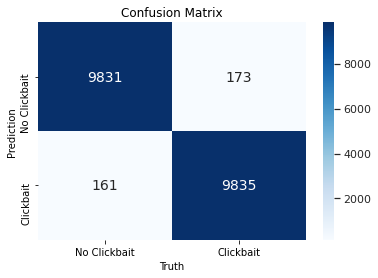

In [12]:
model_weights = {'KNN': 0.7866810233035141,
 'LR': 0.8036572275670447,
 'NB': 0.9102009774357307,
 'RF': 0.1559824350958057,
 'SVM': 0.9355079606348642,
 'XGB': 0.33469066125332436,
 'simple_nn': 0.000545264707939086}





y_pred_prob = 0
for model_name, model in model_dict.items():
    if model_name == 'XGB':
        y_pred_prob += (model.predict_proba(test_features.todense())[:,1] * model_weights[model_name])
    else:   
        y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())
print_model_metrics(y_test, y_pred_prob, confusion = True)



In [13]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
    
#Find the threshold value that gives the best F1 Score
best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

# Calulcate predictions based on the threshold value
y_test_pred = np.where(y_test_prob > best_threshold, 1, 0)

In [14]:
misclassified_idx = y_test != y_test_pred
high_confidence_indices = np.argsort(y_test_prob[misclassified_idx])[-10:]

In [15]:
for idx in high_confidence_indices:
    print('Title : {}'.format(test[misclassified_idx].title.values[idx]))
    print('Label : {}'.format(test[misclassified_idx].label.values[idx]))
    print('Predicted Probability : {}'.format(y_test_prob[misclassified_idx][idx]))
    print('-' * 10)

Title : Like Bats, Shrews Let Echoes Be Their Guide
Label : not-clickbait
Predicted Probability : 0.9602175934546525
----------
Title : Just Browsing? A Web Store May Follow You Out the Door
Label : not-clickbait
Predicted Probability : 0.9614956922582023
----------
Title : Florida Pharmacy Admits Error That Might Have Killed Polo Ponies
Label : not-clickbait
Predicted Probability : 0.971754878830899
----------
Title : Curlers Prove Not All Brazilian Sweepers Play Soccer
Label : not-clickbait
Predicted Probability : 0.9765613662020515
----------
Title : Evidence That Mice Produce Egg Cells After Birth
Label : not-clickbait
Predicted Probability : 0.9843639222791714
----------
Title : Remembering Srebrenice massacre
Label : not-clickbait
Predicted Probability : 0.9882503977035892
----------
Title : Kosher Label Missing From Girl Scout Cookies
Label : not-clickbait
Predicted Probability : 0.9923747465122486
----------
Title : Is This a Shakespeare Which I See Before Me?
Label : not-click

In [16]:
test[test.label.values == 'not-clickbait'].sample(10).title.values

array(['Knicks Try Out Guard Morris Almond and Like What They See',
       'US military to withdraw military trainers from Pakistan',
       'Charles Manson releases album under free license',
       'Sri Lanka Orders Halt to Fighting Circled Rebels',
       'Stopgap at Shortstop? Boston Hopes for More',
       'Plan to Make Gowanus Canal a Superfund Site Draws Opposition',
       'Two Knicks Who Are Worth Keeping', 'AOL to launch VoIP service',
       'Federal response to Katrina a "national disgrace"',
       'Evolutionary biology labs at University of Colorado threatened'],
      dtype=object)